In [2]:
!pip install -q tensorflow gradio scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gradio as gr



In [5]:
# Cell 2 — upload (run, then choose file in the pop-up)
from google.colab import files
import io

print("Select your CSV file in the file chooser that appears...")
uploaded = files.upload()   # after this completes, uploaded is a dict {filename: bytes}

# If you uploaded more than one file, this picks the first filename
filename = list(uploaded.keys())[0]
print("Uploaded filename:", filename)

# Read into pandas (try default engine first)
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')
print("Loaded dataframe shape:", df.shape)
df.head(5)

Select your CSV file in the file chooser that appears...


Saving spam.csv to spam (2).csv
Uploaded filename: spam (2).csv
Loaded dataframe shape: (5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

split_index = int(len(df) * 0.8)

train_df = df[:split_index]
test_df  = df[split_index:]

X_train = train_df['text'].tolist()
y_train = train_df['label'].values

X_test  = test_df['text'].tolist()
y_test  = test_df['label'].values

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 4457
Testing samples: 1115


In [18]:
# Text Preprocessing
tokenizer = Tokenizer(num_words=None, oov_token='<unk>') # num_words=None means it will keep all words
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1 # +1 for the OOV token or padding

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = max([len(seq) for seq in X_train_sequences]) # Max length of sequences in training data

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Convert labels to numerical
label_map = {'ham': 0, 'spam': 1}
y_train_encoded = np.array([label_map[label] for label in y_train])
y_test_encoded = np.array([label_map[label] for label in y_test])

model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train_padded, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


126/126 - 4s - 31ms/step - accuracy: 0.8606 - loss: 0.3943 - val_accuracy: 0.8543 - val_loss: 0.4006
Epoch 2/10
126/126 - 0s - 3ms/step - accuracy: 0.8661 - loss: 0.3756 - val_accuracy: 0.8543 - val_loss: 0.3939
Epoch 3/10
126/126 - 0s - 3ms/step - accuracy: 0.8661 - loss: 0.3679 - val_accuracy: 0.8543 - val_loss: 0.3803
Epoch 4/10
126/126 - 0s - 3ms/step - accuracy: 0.8661 - loss: 0.3509 - val_accuracy: 0.8543 - val_loss: 0.3589
Epoch 5/10
126/126 - 0s - 3ms/step - accuracy: 0.8661 - loss: 0.3257 - val_accuracy: 0.8632 - val_loss: 0.3295
Epoch 6/10
126/126 - 0s - 3ms/step - accuracy: 0.8813 - loss: 0.2545 - val_accuracy: 0.9731 - val_loss: 0.2990
Epoch 7/10
126/126 - 0s - 3ms/step - accuracy: 0.9392 - loss: 0.1697 - val_accuracy: 0.9439 - val_loss: 0.1515
Epoch 8/10
126/126 - 0s - 3ms/step - accuracy: 0.9678 - loss: 0.1092 - val_accuracy: 0.9709 - val_loss: 0.1030
Epoch 9/10
126/126 - 0s - 3ms/step - accuracy: 0.9803 - loss: 0.0771 - val_accuracy: 0.9731 - val_loss: 0.0871
Epoch 10/10

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 189, 64)        │       510,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,577 (1.96 MB)

 Trainable params: 512,577 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.9838565022421525

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       970
           1       0.95      0.92      0.94       145

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



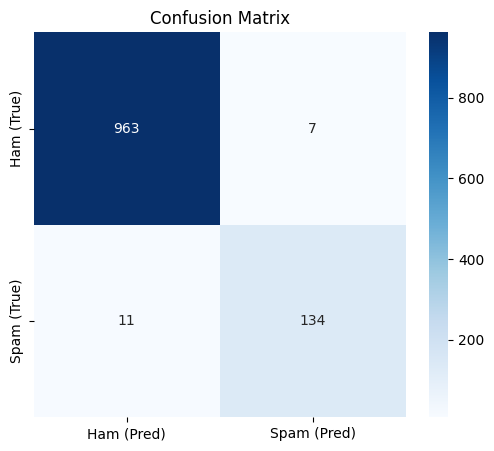

In [38]:
y_pred_prob = model.predict(X_test_padded).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test_encoded, y_pred))

cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham (Pred)', 'Spam (Pred)'],
            yticklabels=['Ham (True)', 'Spam (True)'])
plt.title("Confusion Matrix")
plt.show()

In [22]:
model.save("sms_model.h5")

import json
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

print("Saved sms_model.h5 and tokenizer.json")


Saved sms_model.h5 and tokenizer.json


In [26]:
def predict_sms(text):
    txt = str(text).lower().strip()
    seq = tokenizer.texts_to_sequences([txt])
    pad = pad_sequences(seq, maxlen=max_len)

    prob = float(model.predict(pad)[0][0])
    label = "spam" if prob >= 0.5 else "ham (legit)"
    confidence = prob if prob >= 0.5 else 1 - prob

    return {
        "prediction": label,
        "probability_spam": f"{prob:.4f}",
        "confidence": f"{confidence:.2%}"
    }


In [39]:
import gradio as gr

def predict_sms(text):
    seq = tokenizer.texts_to_sequences([text])
    max_len = model.input_shape[1]
    padded = pad_sequences(seq, maxlen=max_len, padding='post')

    pred = model.predict(padded)[0][0]

    prediction = "SPAM / FAKE" if pred > 0.5 else "HAM / LEGIT"
    confidence = pred if pred > 0.5 else (1 - pred)

    return prediction, str(pred), str(confidence)


gui = gr.Interface(
    fn=predict_sms,
    inputs=gr.Textbox(lines=3, label="Enter SMS Message"),
    outputs=[
        gr.Label(label="Prediction"),
        gr.Textbox(label="Spam Probability"),
        gr.Textbox(label="Confidence")
    ],
    title="SMS Spam / Legit Checker (ANN Model)",
    description="Paste an SMS and click Submit."
)

gui.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://daf7e5851e7e8a231e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [30]:
from google.colab import files
files.download("sms_model.h5")
files.download("tokenizer.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
!apt-get install git -y
!git --version
!git config --global user.name "raxitt028"
!git config --global user.email "chauhanraxit28@gmail.com"
!mkdir sms_spam_model
!cd sms_spam_model
!cp sms_model.keras sms_spam_model/
!cp tokenizer.json sms_spam_model/


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
git version 2.34.1
mkdir: cannot create directory ‘sms_spam_model’: File exists
cp: cannot stat 'sms_model.keras': No such file or directory


KeyboardInterrupt: 